In [1]:
import zipfile
import os

# TODO: Set the correct uploaded ZIP filename
zip_path = 'dataset.zip' # <-- replace with the exact uploaded filename
extract_path = './dataset' # folder where you want to extract
# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 zip_ref.extractall(extract_path)
print(f"✅ Unzipped to: {os.path.abspath(extract_path)}")
# Optional: List the extracted folder contents
print("Contents:")
print(os.listdir(extract_path))

✅ Unzipped to: /home/josh/ML-Labs/LAB8/dataset
Contents:
['inclusion', 'scratches', 'rolled-in_scale', 'patches', 'pitted_surface', 'crazing']


In [2]:
import shutil
import random

SOURCE_DIR = 'dataset' # folder from unzip
TARGET_DIR = 'dataset_split' # new folder to store split data
# Split ratios
train_ratio = 0.7
test_ratio = 0.3 # note: you can calculate this as 1 - train_ratio if needed
# Set random seed for reproducibility
random.seed(42)
# Create target train/test directories per class
for split in ['train', 'test']:
 for class_name in os.listdir(SOURCE_DIR):
    os.makedirs(os.path.join(TARGET_DIR, split, class_name), exist_ok=True)
# Process each class folder
for class_name in os.listdir(SOURCE_DIR):
 class_path = os.path.join(SOURCE_DIR, class_name)
 if not os.path.isdir(class_path):
     continue
 images = os.listdir(class_path)
 random.shuffle(images)
 # Calculate split point
 train_cutoff = int(len(images) * train_ratio)
 # Split images
 train_images = images[:train_cutoff]
 test_images = images[train_cutoff:]
 # Copy training images
 for img_name in train_images:
    src = os.path.join(class_path, img_name)
    dst = os.path.join(TARGET_DIR, 'train', class_name, img_name)
    shutil.copyfile(src, dst)
 # Copy testing images
 for img_name in test_images:
    src = os.path.join(class_path, img_name)
    dst = os.path.join(TARGET_DIR, 'test', class_name, img_name)
    shutil.copyfile(src, dst)
    
    
print("✅ Dataset split complete!")

✅ Dataset split complete!


Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Train samples: 1260
Test samples: 540


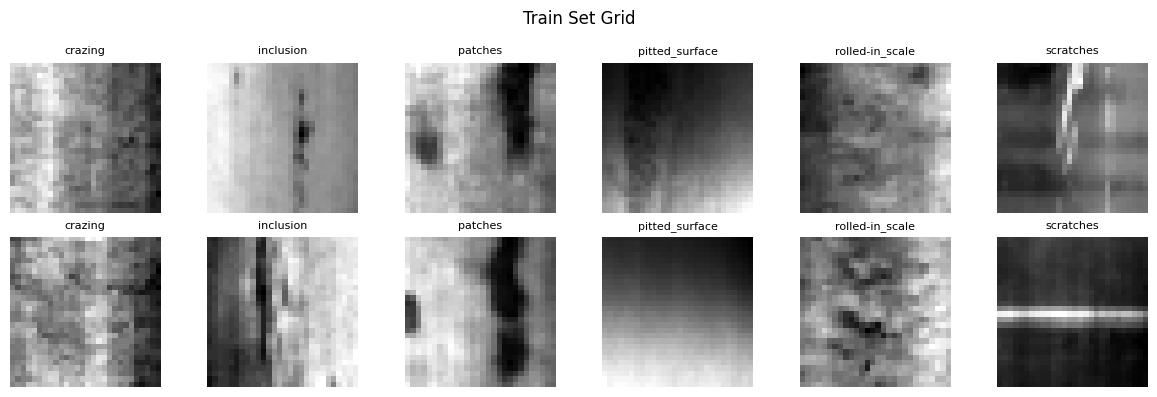

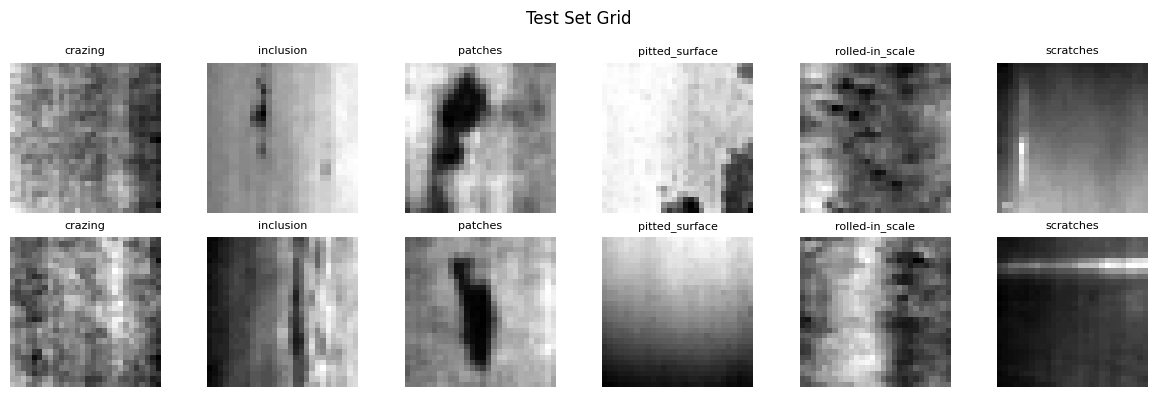

In [3]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set dataset paths (update if needed)
TRAIN_PATH = 'dataset_split/train'
TEST_PATH = 'dataset_split/test'
# Define image transforms: resize, grayscale, tensor, normalize
transform_custom = transforms.Compose([
transforms.Resize((28, 28)),
transforms.Grayscale(num_output_channels=1),
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])
# Load datasets
train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_custom)
test_set = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform_custom)
# Print dataset info
print("Classes:", train_set.classes)
print("Train samples:", len(train_set))
print("Test samples:", len(test_set))
# Show example images (2 per class)

def show_2x6_grid(dataset, n_per_class=2, title="Example Grid"):
    class_counts = {i: 0 for i in range(len(dataset.classes))}
    collected = {i: [] for i in range(len(dataset.classes))}
    for img, label in dataset:
        if class_counts[label] < n_per_class:
            collected[label].append(img)
            class_counts[label] += 1
        if all(c >= n_per_class for c in class_counts.values()):
            break
        
        
    fig, axes = plt.subplots(n_per_class, len(dataset.classes), figsize=(len(dataset.classes)*2, n_per_class*2))
    for col, imgs in collected.items():
        for row in range(n_per_class):
            ax = axes[row][col] if n_per_class > 1 else axes[col]
            img = imgs[row].numpy().transpose(1, 2, 0) * 0.5 + 0.5 # unnormalize
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(dataset.classes[col], fontsize=8)
            ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
# Show training and test grids
show_2x6_grid(train_set, 2, "Train Set Grid")
show_2x6_grid(test_set, 2, "Test Set Grid")

In [4]:
import torch
import torch.nn as nn
from einops import rearrange
from einops.layers.torch import Rearrange

# === 工具函數 ===
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# === 1. PreNorm ===
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# === 2. FeedForward ===
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

# === 3. Attention ===
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        self.heads = heads
        self.dim_head = dim_head
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        self.scale = dim_head ** -0.5

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)  # q, k, v
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = (q @ k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        attn = self.dropout(attn)

        out = attn @ v
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# === 4. Transformer ===
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# === 5. Vision Transformer (ViT) ===
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads,
                 mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image must be divisible by patch size'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.patch_embedding = nn.Sequential(
            Rearrange('b c (h ph) (w pw) -> b (h w) (ph pw c)',
                      ph=patch_height, pw=patch_width),
            nn.Linear(patch_dim, dim)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.patch_embedding(img)  # (B, N, D)
        b, n, _ = x.shape
        cls_tokens = self.cls_token.expand(b, -1, -1).to(x.device)
        pos_emb = self.pos_embedding[:, :n + 1].to(x.device)
        cls_tokens = self.cls_token.expand(b, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, D)
        x = x + self.pos_embedding[:, :n + 1]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x[:, 0] if self.pool == 'cls' else x.mean(dim=1)
        x = self.to_latent(x)
        return self.mlp_head(x)



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(
    image_size=28,
    patch_size=4,
    num_classes=6,
    channels=1,         # 灰階圖片
    dim=192,
    depth=10,
    heads=8,
    dim_head=64,
    mlp_dim=384,
    dropout=0.1,
    emb_dropout=0.1
)
import torch.optim as optim

# 定義 optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)




In [6]:
from torchinfo import summary


summary(model, input_size=(1, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "kernel_size"], depth=5)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ViT                                                [1, 1, 28, 28]            [1, 6]                    9,792                     --
├─Sequential: 1-1                                  [1, 1, 28, 28]            [1, 49, 192]              --                        --
│    └─Rearrange: 2-1                              [1, 1, 28, 28]            [1, 49, 16]               --                        --
│    └─Linear: 2-2                                 [1, 49, 16]               [1, 49, 192]              3,264                     --
├─Dropout: 1-2                                     [1, 50, 192]              [1, 50, 192]              --                        --
├─Transformer: 1-3                                 [1, 50, 192]              [1, 50, 192]              --                        --
│    └─ModuleList: 2-3                             --             

In [7]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")
def train_epoch(model, optimizer, data_loader, loss_history):
    
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_samples = len(data_loader.dataset)

    for i, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()                    # 歸零梯度
        output = model(data)                     # 前向傳播
        loss = criterion(output, target)         # 計算 loss
        loss.backward()                          # 反向傳播
        optimizer.step()                         # 優化器更新

        if i % 100 == 0:
            print(f"Train Step {i}/{len(data_loader)} - Loss: {loss.item():.4f}")
            loss_history.append(loss.item())
def evaluate(model, data_loader, loss_history):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            preds = torch.argmax(output, dim=1)
            correct_samples += (preds == target).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_samples / total_samples * 100
    loss_history.append(avg_loss)

    print(f"✅ Evaluation - Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


✅ Using device: cuda


In [8]:
import time

# 建立 DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


# 放模型到 device
model = model.to(device)
# 訓練參數
N_EPOCHS = 20
train_loss_history, test_loss_history = [], []

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
# 開始訓練
start_time = time.time()

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n🎯 Epoch {epoch}/{N_EPOCHS}")
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)
    scheduler.step()

print('⏱️ Total training time:', '{:.2f}'.format(time.time() - start_time), 'seconds')

# 儲存模型
torch.save(model.state_dict(), '313512065_vit.pth')  # 替換為你的學號檔名
print("✅ Model saved as student_id_vit.pth")




🎯 Epoch 1/20
Train Step 0/20 - Loss: 1.9222
✅ Evaluation - Avg Loss: 1.5453, Accuracy: 38.52%

🎯 Epoch 2/20
Train Step 0/20 - Loss: 1.4829
✅ Evaluation - Avg Loss: 1.3959, Accuracy: 46.48%

🎯 Epoch 3/20
Train Step 0/20 - Loss: 1.3952
✅ Evaluation - Avg Loss: 1.0074, Accuracy: 62.78%

🎯 Epoch 4/20
Train Step 0/20 - Loss: 1.1732
✅ Evaluation - Avg Loss: 0.8694, Accuracy: 67.96%

🎯 Epoch 5/20
Train Step 0/20 - Loss: 1.0969
✅ Evaluation - Avg Loss: 0.7324, Accuracy: 70.93%

🎯 Epoch 6/20
Train Step 0/20 - Loss: 0.8721
✅ Evaluation - Avg Loss: 0.7263, Accuracy: 70.93%

🎯 Epoch 7/20
Train Step 0/20 - Loss: 0.8022
✅ Evaluation - Avg Loss: 0.6352, Accuracy: 75.56%

🎯 Epoch 8/20
Train Step 0/20 - Loss: 0.5796
✅ Evaluation - Avg Loss: 0.6032, Accuracy: 76.48%

🎯 Epoch 9/20
Train Step 0/20 - Loss: 0.5296
✅ Evaluation - Avg Loss: 0.5905, Accuracy: 77.59%

🎯 Epoch 10/20
Train Step 0/20 - Loss: 0.5294
✅ Evaluation - Avg Loss: 0.5401, Accuracy: 80.19%

🎯 Epoch 11/20
Train Step 0/20 - Loss: 0.3586
✅ E

In [10]:
# 載入模型前，先定義相同結構
model = ViT(
    image_size=28,
    patch_size=4,
    num_classes=6,
    channels=1,         # 灰階圖片
    dim=192,
    depth=10,
    heads=8,
    dim_head=64,
    mlp_dim=384,
    dropout=0.1,
    emb_dropout=0.1
).to(device)
model.load_state_dict(torch.load('313512065_vit.pth'))
model.eval()
print("✅ Model loaded and ready for inference")


✅ Model loaded and ready for inference


/tmp/ipykernel_2957558/147210143.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('313512065_vit.pth'))


In [11]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
def plot_classwise_predictions(model, data_loader, class_names, samples_per_class=4):
    model.eval()
    collected = {i: [] for i in range(len(class_names))}

    with torch.no_grad():
        for imgs, labels in data_loader:
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            for img, label, pred in zip(imgs, labels, preds):
                if len(collected[label.item()]) < samples_per_class:
                    collected[label.item()].append((img, label.item(), pred.item()))

            if all(len(v) >= samples_per_class for v in collected.values()):
                break

    fig, axes = plt.subplots(samples_per_class, len(class_names), figsize=(len(class_names)*2.5, samples_per_class*2.5))

    for class_idx, examples in collected.items():
        for i, (img, true, pred) in enumerate(examples):
            ax = axes[i][class_idx] if samples_per_class > 1 else axes[class_idx]
            img = img.squeeze().numpy() * 0.5 + 0.5  # 反標準化
            ax.imshow(img, cmap='gray')
            ax.set_title(f"T:{class_names[true]}\nP:{class_names[pred]}", fontsize=8)
            ax.axis('off')

    plt.suptitle("Classwise Predictions (True vs Predicted)", fontsize=14)
    plt.tight_layout()
    plt.show()


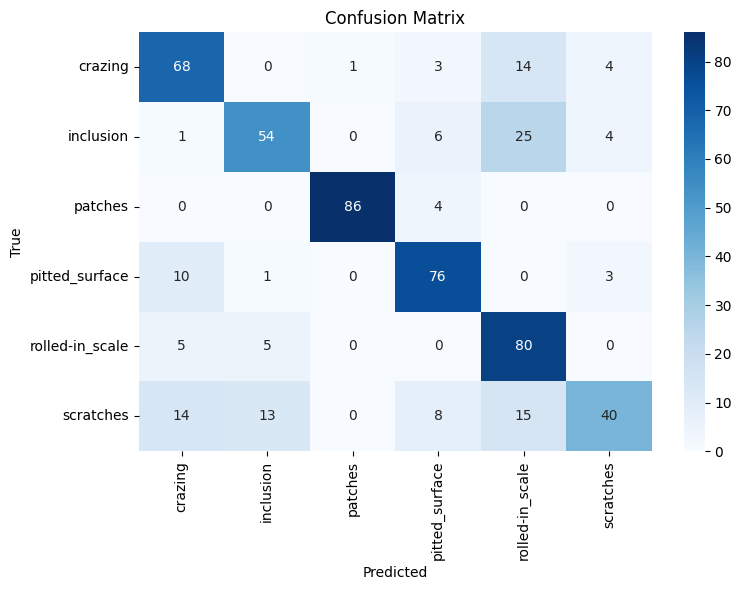

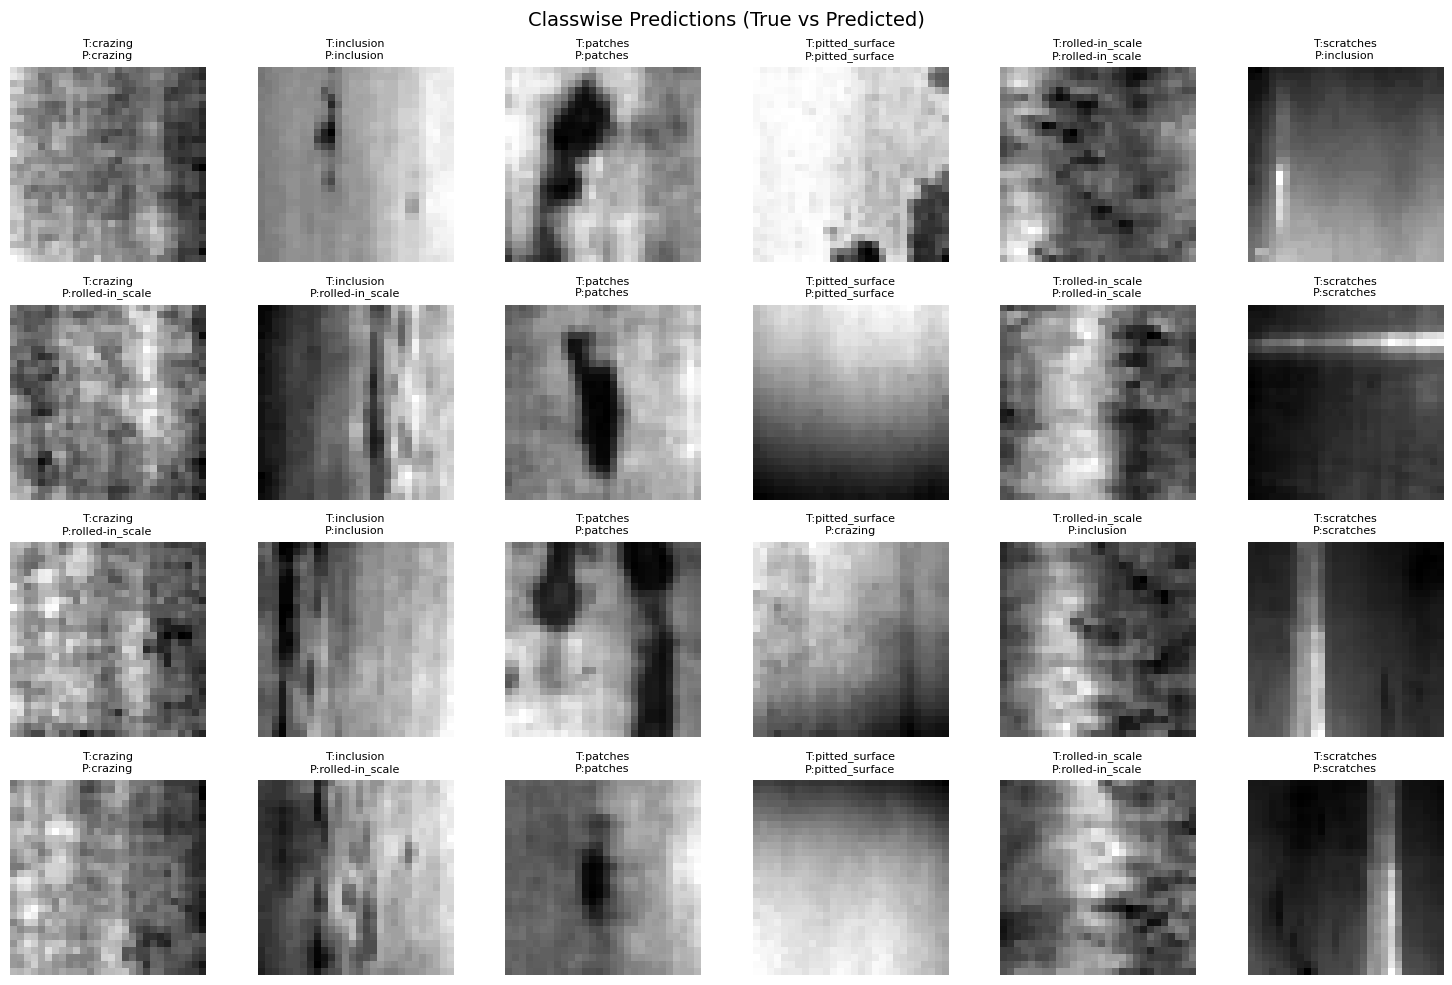

In [ ]:
# 確保 test_loader 和 train_set.classes 已定義
plot_confusion_matrix(model, test_loader, train_set.classes)
plot_classwise_predictions(model, test_loader, train_set.classes, samples_per_class=4)
